In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# apply some styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

In [2]:
weather_df = pd.read_csv('cleaned_weather.csv')
# read the solar plant generation data
solar_df = pd.read_csv('plant_output.csv')
# drop unused columns
solar_df = solar_df.drop(['Plant', 'Real-time power(kW)', 'Daily feed-in energy(kWh)', 'Energy purchased today(kWh)'], axis=1)

# Both weather and solar df are date aligned
data_df = weather_df
data_df['output'] = solar_df['Daily yield(kWh)']
# Remove entries with known 0 output
data_df = data_df[~(data_df['output'] == 0)]
data_df.drop(data_df.columns[0], axis=1, inplace=True)

/var/folders/zh/nt4cvtjd1bl_ntm3_d6kztf40000gn/T/ipykernel_44386/720678684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.drop(data_df.columns[0], axis=1, inplace=True)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
scaler = StandardScaler()
numeric_cols = data_df.select_dtypes(include=[np.number]).columns
data_df = data_df[numeric_cols]
data_norm = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)
data_norm.head(5)

,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,cloudcover,solarradiation,solarenergy,solartime,output
0,-1.403946,-0.829721,-1.376138,0.242118,1.004365,-0.293308,-0.6003,-0.451987,-0.883851,-0.680943,-0.651917,-1.509529,-0.281256
1,-0.916350,-1.188969,-1.340224,-0.316047,0.483319,-0.293308,-0.6003,-0.451987,-0.686336,-0.583275,-0.588037,-1.502480,-0.042159
2,-1.322680,-1.787716,-1.735276,-1.127923,0.024799,-0.293308,-0.6003,-0.451987,0.044818,-0.513248,-0.502863,-1.495189,0.017616
3,-1.187236,-2.296651,-2.094413,-1.584603,-0.301724,-0.293308,-0.6003,-0.451987,-0.859595,-0.476393,-0.460277,-1.487654,-0.639903
4,-1.105970,-1.997277,-1.843017,-1.178665,-0.114147,-0.293308,-0.6003,-0.451987,-0.280909,-0.588803,-0.566744,-1.479148,-0.460580


In [4]:
# Split data 
X = data_norm.drop('output', axis=1)
y = data_norm['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
print( 'X ', X.shape)
print( 'y ', y.shape)
print( 'X_train ', X_train.shape)
print( 'y_train ', y_train.shape)

X  (151, 12)
y  (151,)
X_train  (120, 12)
y_train  (120,)


In [5]:
from ParamTester import ParamTester
from ParamTester import predict_and_eval

In [6]:
rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)

rf_metrics, rf_y_train_pred, rf_y_test_pred = predict_and_eval(rf_reg, X_train, y_train, X_test, y_test)

Train Mean Squared Error: 0.06659938118489624
Train R-squared: 0.938472299682358
Test Mean Squared Error: 0.6681589174850939
Test R-squared: 0.014030966299532155


In [7]:
print ('features: ',rf_reg.n_features_in_)
print ('params: ',rf_reg.get_params())

features:  12
params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [8]:
# It seems the the RandomForestRegressor model have high bias(underfitting). Let's try adding more features using PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly  = poly.fit_transform(X)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [9]:
rf_poly_reg = RandomForestRegressor(random_state=0)
rf_poly_reg.fit(X_poly_train, y_poly_train)

rf_poly_metrics, rf_poly_y_train_pred, rf_poly_y_test_pred = predict_and_eval(rf_poly_reg, X_poly_train, y_poly_train, X_poly_test, y_poly_test)

Train Mean Squared Error: 0.06844087671953901
Train R-squared: 0.9287898058998093
Test Mean Squared Error: 0.6769804363071698
Test R-squared: 0.3995077076239393


In [10]:
print ('features: ',rf_poly_reg.n_features_in_)
print ('params: ',rf_poly_reg.get_params())

features:  90
params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


### Observations
1. Polynomial features significantly improved the R2 score 
2. At the same time, the training R2 score of 0.92 indicates overfitting

To address this, following variations with n_estimators, max_features, etc are performed.

In [11]:
param_info = [
    {
        'name': 'max_features',
        'type': 'int',
        'params': {'random_state' : 0},
        'values': [10, 20, 30, 40, 50, 60, 70, 80]
    },
    {        
        'name': 'n_estimators',
        'type': 'int',
        'params': {'random_state' : 0},
        'values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
    },
    {        
        'name': 'max_depth',
        'type': 'int',
        'params': {'random_state' : 0},
        'values': [4, 8, 12, 16, 20, 24, 28, 32]
    }
]
pt = ParamTester(RandomForestRegressor, X_poly_train, y_poly_train, X_poly_test, y_poly_test)
pt.init_test_params(param_info)
pt.get_attr('param_info')
pt.get_attr('best_params')

Parameter information:
Parameter: max_features, Values: [10, 20, 30, 40, 50, 60, 70, 80], Params: {'random_state': 0}
Parameter: n_estimators, Values: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], Params: {'random_state': 0}
Parameter: max_depth, Values: [4, 8, 12, 16, 20, 24, 28, 32], Params: {'random_state': 0}
Current best parameters:


--- Running tests for parameter: max_features ---
Updated params: {'random_state': 0}
-- Testing max_features with value: 10 with {'random_state': 0, 'max_features': 10}
Train Mean Squared Error: 0.06592921882137324
Train R-squared: 0.9314030927981433
Test Mean Squared Error: 0.6145786259771222
Test R-squared: 0.45485909464172325
-- Testing max_features with value: 20 with {'random_state': 0, 'max_features': 20}
Train Mean Squared Error: 0.06869116400277789
Train R-squared: 0.9285293912634907
Test Mean Squared Error: 0.6459348434174087
Test R-squared: 0.4270456367024211
-- Testing max_features with value: 30 with {'random_state': 0, 'max_features': 30}
Train Mean Squared Error: 0.06662064116317538
Train R-squared: 0.9306836934928611
Test Mean Squared Error: 0.6270915551840001
Test R-squared: 0.443759929672105
-- Testing max_features with value: 40 with {'random_state': 0, 'max_features': 40}
Train Mean Squared Error: 0.06993984326902852
Train R-squared: 0.927230186794165
Test Mean Squa

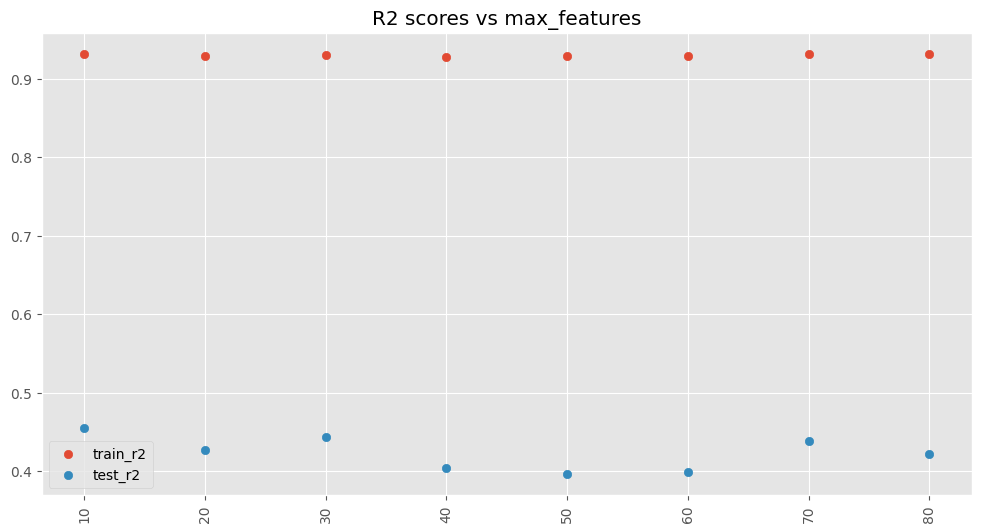

--- Running tests for parameter: n_estimators ---
Updated params: {'random_state': 0, 'max_features': 10}
-- Testing n_estimators with value: 10 with {'random_state': 0, 'max_features': 10, 'n_estimators': 10}
Train Mean Squared Error: 0.09626562231564843
Train R-squared: 0.899839189986356
Test Mean Squared Error: 0.5945819882862435
Test R-squared: 0.47259642671635493
-- Testing n_estimators with value: 20 with {'random_state': 0, 'max_features': 10, 'n_estimators': 20}
Train Mean Squared Error: 0.08345529626988316
Train R-squared: 0.9131678591666742
Test Mean Squared Error: 0.5422223364078015
Test R-squared: 0.5190402612767853
-- Testing n_estimators with value: 30 with {'random_state': 0, 'max_features': 10, 'n_estimators': 30}
Train Mean Squared Error: 0.07689660260622927
Train R-squared: 0.9199919366948797
Test Mean Squared Error: 0.5567114686368
Test R-squared: 0.5061881731511789
-- Testing n_estimators with value: 40 with {'random_state': 0, 'max_features': 10, 'n_estimators': 40

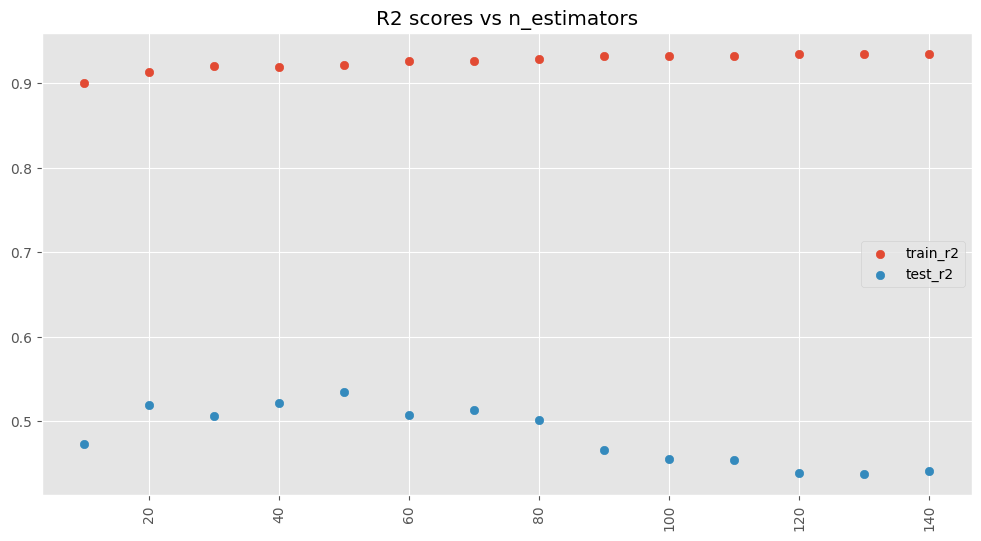

--- Running tests for parameter: max_depth ---
Updated params: {'random_state': 0, 'max_features': 10, 'n_estimators': 50}
-- Testing max_depth with value: 4 with {'random_state': 0, 'max_features': 10, 'n_estimators': 50, 'max_depth': 4}
Train Mean Squared Error: 0.16552516502885986
Train R-squared: 0.8277772042799367
Test Mean Squared Error: 0.5606354081525323
Test R-squared: 0.5027075770976204
-- Testing max_depth with value: 8 with {'random_state': 0, 'max_features': 10, 'n_estimators': 50, 'max_depth': 8}
Train Mean Squared Error: 0.07885720363654426
Train R-squared: 0.917952004031628
Test Mean Squared Error: 0.5498211472597802
Test R-squared: 0.5122999965614157
-- Testing max_depth with value: 12 with {'random_state': 0, 'max_features': 10, 'n_estimators': 50, 'max_depth': 12}
Train Mean Squared Error: 0.07500125954552388
Train R-squared: 0.921963970860841
Test Mean Squared Error: 0.5333742180141452
Test R-squared: 0.5268886814267151
-- Testing max_depth with value: 16 with {'ran

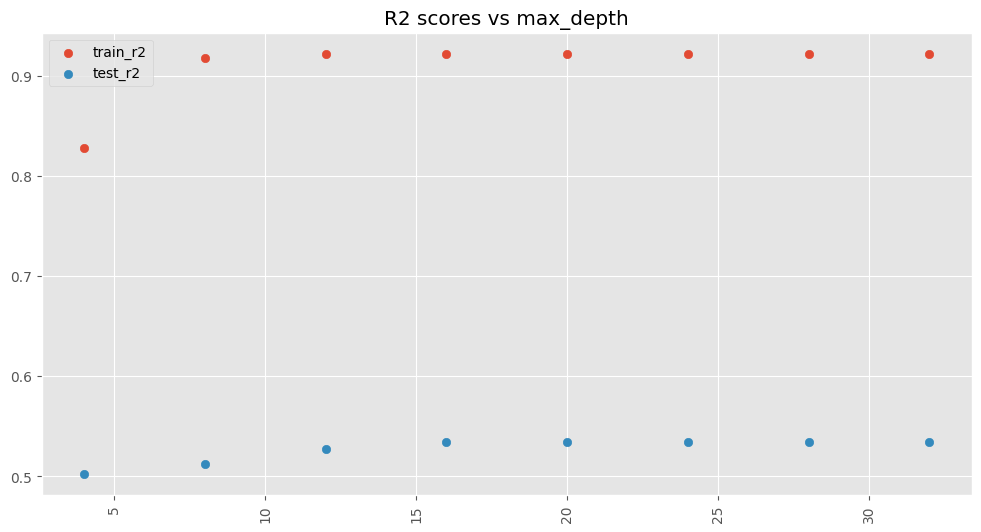

In [12]:
pt.run_param_tests()

In [13]:
pt.get_attr('best_params')

Current best parameters:
max_features: 10
n_estimators: 50
max_depth: 20


### Observations
- In almost all parameter variations, training R2 score indicates overfitting
- The test R2 score however peaks around 0.45 (`max_features` = 60) before stagnating between 0.4 to 0.44
- R2 score for test data peaks around `n_estimators` =50, while training R2 score being always > 90% indicates overfitting
- R2 score for test data reaches max of 0.53 at `max_depth`=20 and stays stagnant with increasing `max_depth`. At the same time, training R2 score being always > 90% indicates overfitting
- The test R2 score of 0.53 shows no improvement over previously tuned parameters - namely `n_estimators` and `max_features`